In [ ]:

import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,auc
from sklearn.model_selection import cross_val_score
import mediapipe as mp
from sklearn.metrics import confusion_matrix
import seaborn as sns
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels


%matplotlib inline

In [ ]:
data_dir='./ASLdigits'
input_dir='Input'
output_dir='Output'

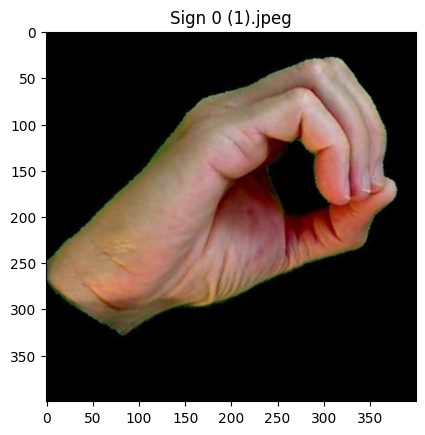

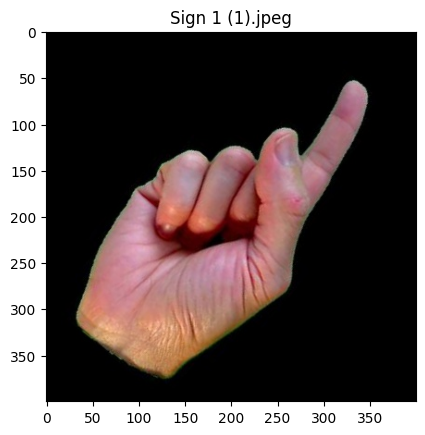

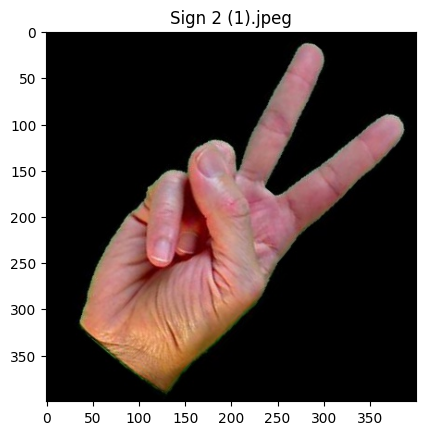

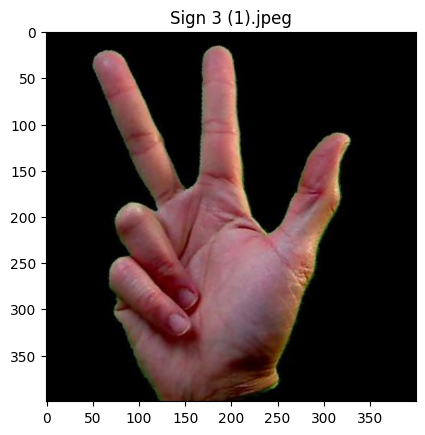

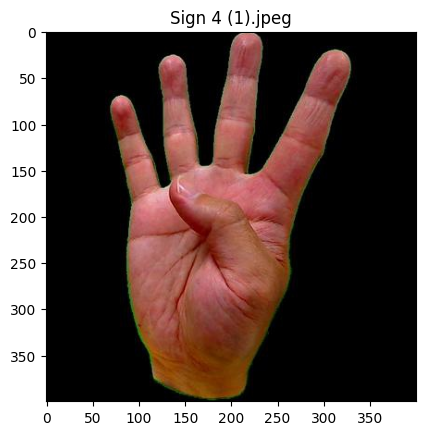

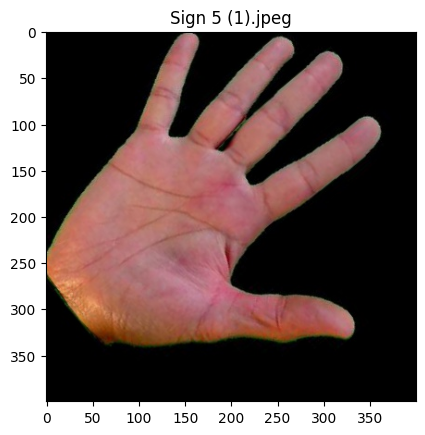

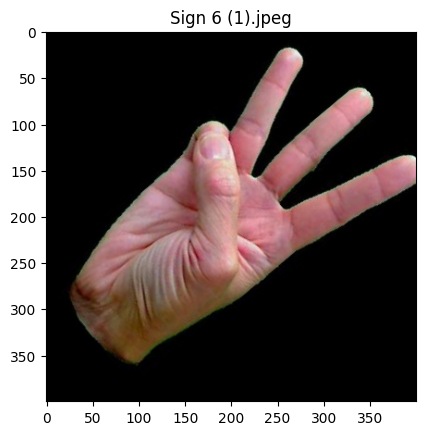

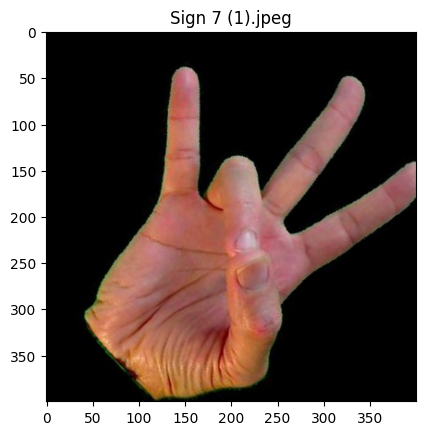

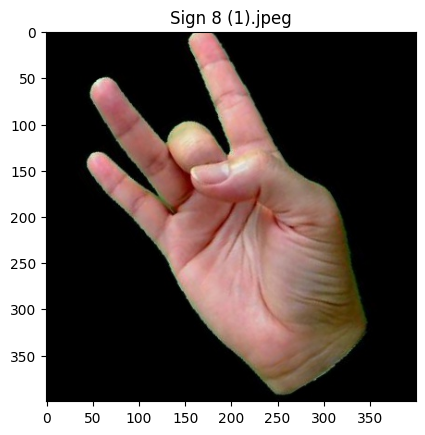

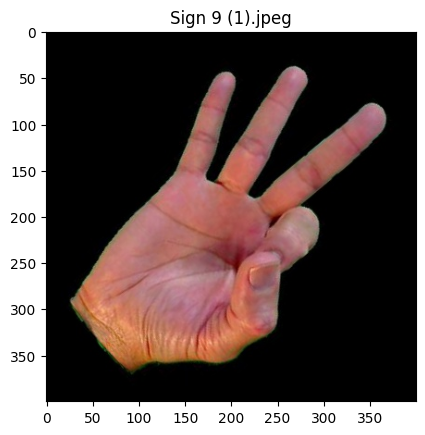

In [ ]:
# example from each data class

for dir in os.listdir(data_dir):
    for img_eg in os.listdir(os.path.join(data_dir,dir,input_dir))[:1]:
        eg = cv2.imread(os.path.join(data_dir,dir,input_dir,img_eg))
        eg_rgb = cv2.cvtColor(eg, cv2.COLOR_BGR2RGB)

        plt.figure()
        plt.imshow(eg_rgb)
        plt.title(img_eg)

In [ ]:
#configure mediapipe

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True,max_num_hands=2,min_detection_confidence=0.7)

In [ ]:


# read from the output files and draw the landmarks

for dir in os.listdir(data_dir):

    outputcounter = 0

    for img_path in os.listdir(os.path.join(data_dir,dir,input_dir)):
        img = cv2.imread(os.path.join(data_dir,dir,input_dir,img_path),1)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        outputs = hands.process(img_rgb)

        # draw landmarks on each image and save the results in the output folder
        if outputs.multi_hand_landmarks:
            outputcounter+=1
            for hand_landmarks in outputs.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    img_rgb,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())
            cv2.imwrite(os.path.join(data_dir,dir,output_dir,img_path),
                        cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))

    print("number of hands detected in images for class",dir,":")

    print(outputcounter,"/500")





number of hands detected in images for class 0 :
76 /500
number of hands detected in images for class 1 :
455 /500
number of hands detected in images for class 2 :
384 /500
number of hands detected in images for class 3 :
479 /500
number of hands detected in images for class 4 :
468 /500
number of hands detected in images for class 5 :
494 /500
number of hands detected in images for class 6 :
392 /500
number of hands detected in images for class 7 :
452 /500
number of hands detected in images for class 8 :
434 /500
number of hands detected in images for class 9 :
481 /500


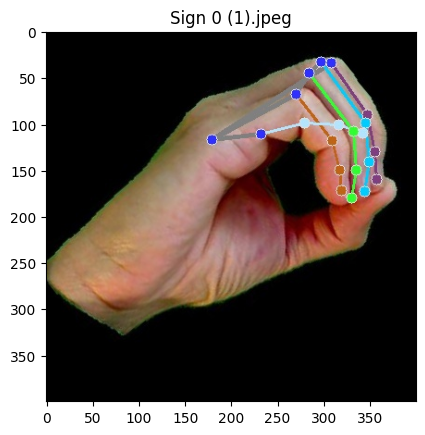

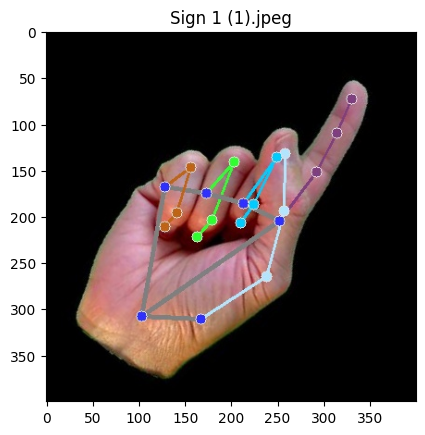

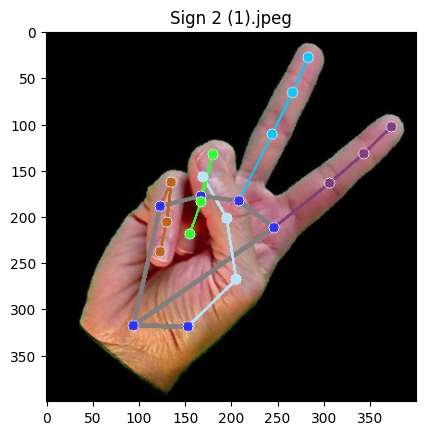

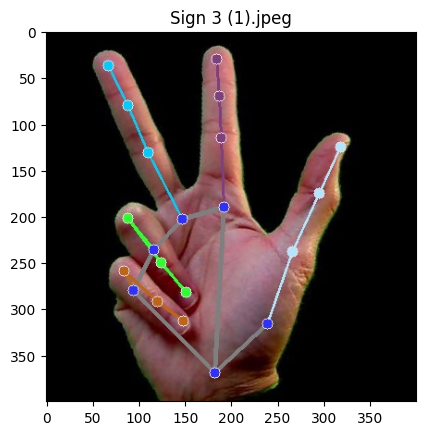

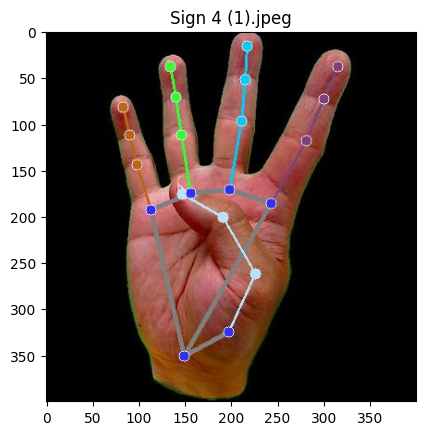

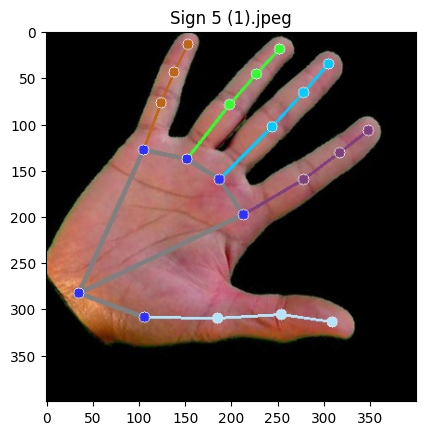

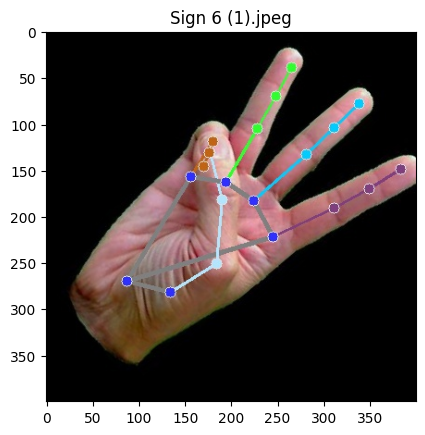

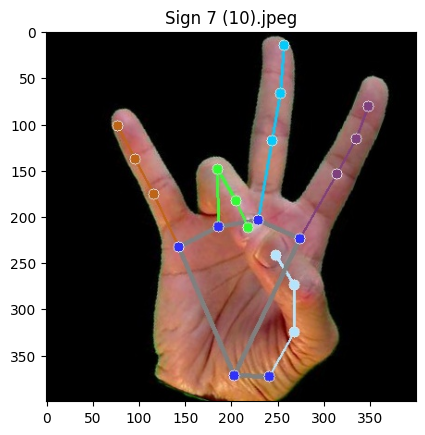

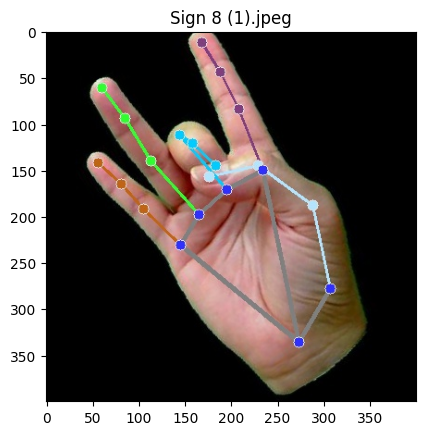

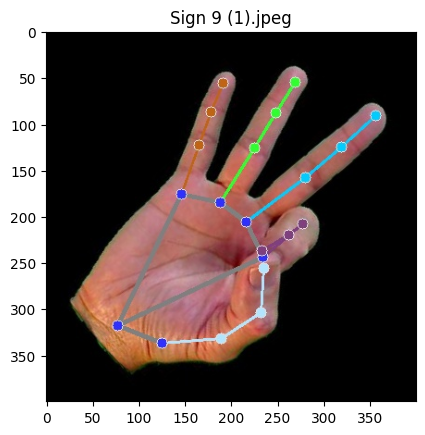

In [ ]:
# example from each data class with landmarks added

for dir in os.listdir(data_dir):
    for img_eg in os.listdir(os.path.join(data_dir,dir,output_dir))[:1]:
        eg = cv2.imread(os.path.join(data_dir,dir,output_dir,img_eg))
        eg_rgb = cv2.cvtColor(eg, cv2.COLOR_BGR2RGB)

        plt.figure()
        plt.imshow(eg_rgb)
        plt.title(img_eg)

In [ ]:
# extracting X,Y coordinates from the landmarks to use as data for the ML models

data=[]
labels=[]

for dir in os.listdir(data_dir):
    for img_path in os.listdir(os.path.join(data_dir,dir,input_dir)):
        img = cv2.imread(os.path.join(data_dir,dir,input_dir,img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        outputs = hands.process(img_rgb)

        landmarkLocations = []

        if outputs.multi_hand_landmarks:
            for hand_landmarks in outputs.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x=hand_landmarks.landmark[i].x
                    y=hand_landmarks.landmark[i].y
                    landmarkLocations.append(x)
                    landmarkLocations.append(y)

            data.append(landmarkLocations)
            labels.append(dir)

In [ ]:
# convert data lists into DataFrames

data=np.array(data)
labels=np.array(labels)
label_df = pd.DataFrame(labels, columns=['label'])
y = label_df['label']
X = pd.DataFrame(data)

print(X)


# there are 21 landmarks in each image. for each, we are saving x and y coordinates
# so the data will have 42 colums.

0       0
1       0
2       0
3       0
4       0
       ..
4110    9
4111    9
4112    9
4113    9
4114    9
Name: label, Length: 4115, dtype: object
            0         1         2         3         4         5         6   \
0     0.448044  0.292593  0.580064  0.279420  0.699461  0.249534  0.791320   
1     0.288463  0.510900  0.285329  0.383874  0.272655  0.260655  0.294447   
2     0.298733  0.558821  0.284425  0.436927  0.255053  0.311697  0.260042   
3     0.288463  0.510900  0.285329  0.383874  0.272655  0.260655  0.294447   
4     0.289864  0.525908  0.298656  0.404997  0.282186  0.281152  0.301012   
...        ...       ...       ...       ...       ...       ...       ...   
4110  0.341253  0.846718  0.475256  0.842628  0.630217  0.756117  0.700955   
4111  0.464068  0.885691  0.585729  0.831730  0.705210  0.702409  0.734426   
4112  0.523339  0.880706  0.635782  0.809192  0.733412  0.664513  0.743599   
4113  0.587322  0.872363  0.686291  0.789863  0.764068  0.619242  0.7

In [ ]:
# split the data into training and testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

In [ ]:
# K Neighbors Classifier

knn = KNeighborsClassifier(n_neighbors=7,weights='uniform')
knn.fit(X_train,y_train)
y_predict_knn = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test,y_predict_knn)

print("KNN accuracy: ", knn_accuracy)

# cross validation for knn

knn = KNeighborsClassifier(n_neighbors=7,weights='uniform')
knn_accuracy_list = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
cv_knn = knn_accuracy_list.mean()
print("KNN cross validation score: ",cv_knn)

KNN accuracy:  0.9990281827016521
KNN cross validation score:  0.9965983984125859


<Axes: >

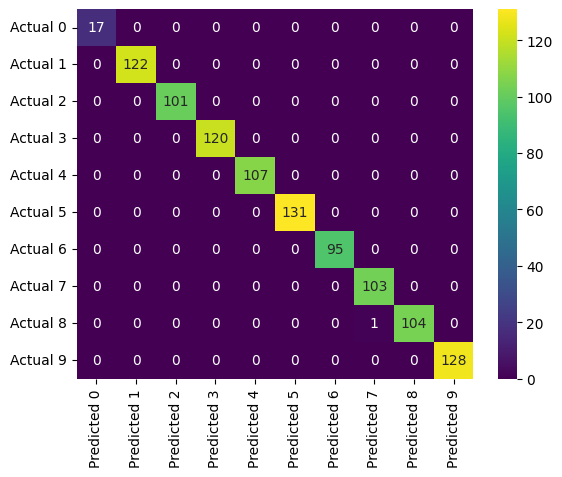

In [ ]:
# confusion matrix for Knn

def plot(y_true, y_pred):
    unq_labels = unique_labels(y_test)
    column = [f'Predicted {label}' for label in unq_labels]
    indeces = [f'Actual {label}' for label in unq_labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),columns = column, index=indeces)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot(y_test,y_predict_knn)

In [ ]:
# Decision Tree Classifier

dt = DecisionTreeClassifier(random_state=5)
dt.fit(X_train,y_train)
y_predict_dt = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_predict_dt)

print("Decision Tree accuracy: ", dt_accuracy)

# cross validation for decision tree

dt = DecisionTreeClassifier(random_state=5)
dt_accuracy_list = cross_val_score(dt, X, y, cv=10, scoring='accuracy')
cv_dt = dt_accuracy_list.mean()
print("Decision Tree cross validation score: ",cv_dt)

Decision Tree accuracy:  0.9795918367346939
Decision Tree cross validation score:  0.957208324474996


<Axes: >

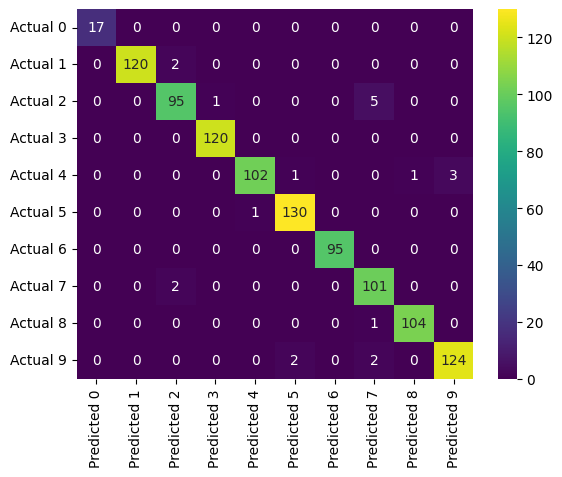

In [ ]:
# confusion matrix for Decision Tree Classifier

plot(y_test,y_predict_dt)

In [ ]:
# Logistic Regression

lr = LogisticRegression(max_iter=400)
lr.fit(X_train,y_train)
y_predict_lr = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_predict_lr)

print("Logistic Regression accuracy: ", lr_accuracy)

# cross validation for logistic regression

lr = LogisticRegression(max_iter=400)
lr_accuracy_list = cross_val_score(lr, X, y, cv=10, scoring='accuracy')
cv_lr = lr_accuracy_list.mean()
print("Logistic Regression cross validation score: ",cv_lr)


Logistic Regression accuracy:  0.9980563654033042
Logistic Regression cross validation score:  0.993437153048449


<Axes: >

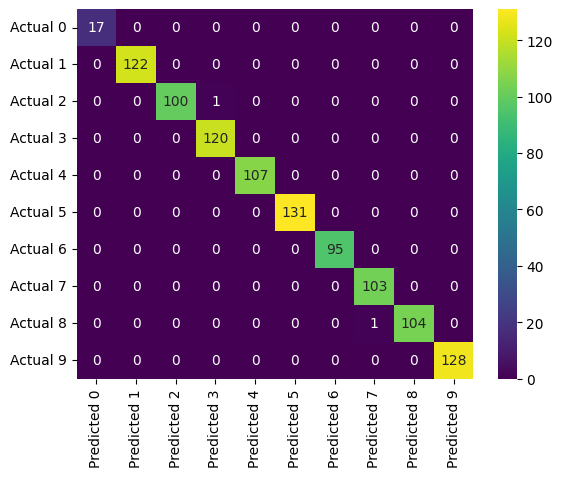

In [ ]:
# confusion matrix for Logistic Regression

plot(y_test,y_predict_lr)

In [ ]:
# Random Forest

rf = RandomForestClassifier(n_estimators = 19, bootstrap = True, random_state=3)
rf.fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_predict_rf)

print("Random Forest accuracy: ", rf_accuracy)



Random Forest accuracy:  0.9961127308066083


<Axes: >

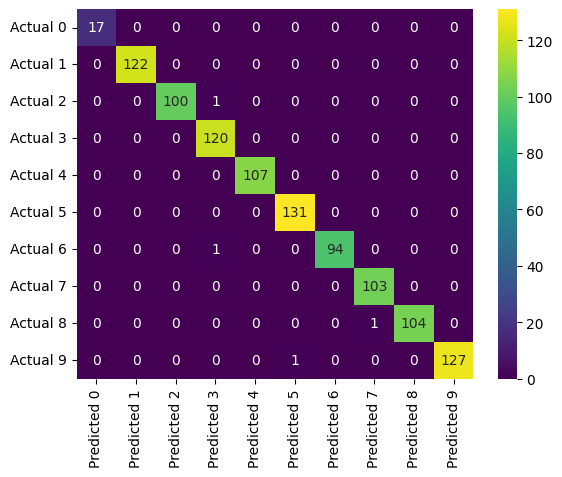

In [ ]:
# confustion matrix for Random Forest

plot(y_test,y_predict_rf)


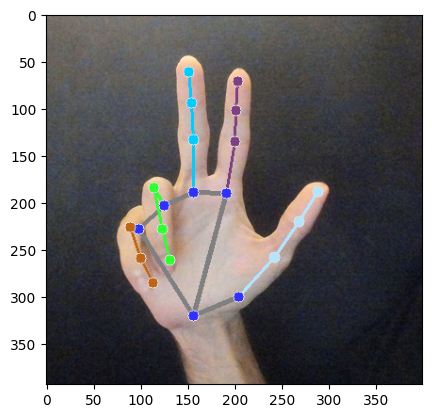

In [ ]:
# testing with image from camera roll


img1 = cv2.imread('./test1.jpg',1)
images=[]
images.append(img1)
images.append(img2)

landmarks_test =[]


image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
outputs = hands.process(image_rgb)

if outputs.multi_hand_landmarks:
    for hand_landmarks in outputs.multi_hand_landmarks:
        for i in range(len(hand_landmarks.landmark)):
            x=hand_landmarks.landmark[i].x
            y=hand_landmarks.landmark[i].y
            landmarks_test.append(x)
            landmarks_test.append(y)
        mp_drawing.draw_landmarks(
            image_rgb,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
        plt.figure()
        plt.imshow(image_rgb)




In [ ]:
# predict with random forest

prediction = rf.predict([np.asarray(landmarks_test)])

print("the image is predicted to show: ", prediction)

the image is predicted to show:  ['3']
